In [ ]:
!pip install scipy matplotlib torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import os, torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from scipy.io import loadmat

## Download Pasccal VOC 2010

In [ ]:
!wget -q --show-progress http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar
!wget -q --show-progress https://roozbehm.info/pascal-parts/trainval.tar.gz

VOCtrainval_03-May- 100%[===================>]   1.25G  15.6MB/s    in 84s     
trainval.tar.gz     100%[===================>]  77.13M   438MB/s    in 0.2s    


In [ ]:
# Unzip the training data
!tar -xf VOCtrainval_03-May-2010.tar && tar -xf trainval.tar.gz

In [ ]:
# Paths for images and annotations
voc_images_dir = "VOCdevkit/VOC2010/JPEGImages"
part_ann_dir = "Annotations_Part"

In [ ]:
# 3. Helper: Load one annotation to understand structure
example_ann = loadmat(os.path.join(part_ann_dir, "2008_000003.mat"))
print(example_ann.keys())

dict_keys(['__header__', '__version__', '__globals__', 'anno'])


In [ ]:
print(example_ann['anno'].dtype)
print(example_ann['anno'].shape)

[('imname', 'O'), ('objects', 'O')]
(1, 1)


## Choose only images with people and reduce classes to head, arms, legs, torso

In [ ]:
import os
import numpy as np
import torch
from scipy.io import loadmat

image_paths = []
mask_tensors = []

# Define lists for exact matches
head_parts = {'head', 'hair', 'left ear', 'right ear', 'left eye', 'right eye',
              'left eyebrow', 'right eyebrow', 'nose', 'mouth'}
torso_parts = {'torso', 'neck', 'body'}

# Loop over all annotation files
for ann_file in os.listdir(part_ann_dir):
    # Load the .mat file
    data = loadmat(os.path.join(part_ann_dir, ann_file))

    # Check for the 'anno' key
    if 'anno' not in data:
        continue
    # Get the actual annotation struct from the 1x1 array
    ann = data['anno'][0, 0]

    # Access the 'objects' field (a 1 x N struct array)
    objects = ann['objects']

    img_mask = None
    has_person = False

    # Loop through each object in the image
    for i in range(objects.shape[1]):
        obj = objects[0, i]
        # Extract object class name (assumes it is stored as a char array)
        obj_class = str(obj['class'][0]).lower()
        if obj_class != 'person':
            continue
        has_person = True

        # Initialize the merged mask using the shape of the object mask
        if img_mask is None:
            h, w = obj['mask'].shape
            img_mask = np.zeros((h, w), dtype=np.uint8)

        # Get parts for this object (should be a 1 x P struct array)
        parts = obj['parts']
        if parts.size == 0:
            continue  # no parts available

        # Loop over each part
        for j in range(parts.shape[1]):
            part = parts[0, j]
            # Get the part mask directly (do not index further)
            part_mask = part['mask']
            # Get the part name; convert from MATLAB char array to string and lower-case it
            part_name = str(part['part_name'][0]).lower()

            # Map the part_name to a category index
            if part_name in head_parts:
                part_idx = 1  # Head category
            elif part_name in torso_parts:
                part_idx = 2  # Torso
            elif ("arm" in part_name) or ("hand" in part_name):
                part_idx = 3  # Arms (both upper and lower)
            elif ("leg" in part_name) or ("foot" in part_name):
                part_idx = 4  # Legs (both upper and lower)
            else:
                continue  # Skip parts that are not human body parts

            # Update the merged image mask: where part_mask is True, set to part_idx
            img_mask[part_mask.astype(bool)] = part_idx

    # If at least one person object was found, store the image path and corresponding mask
    if has_person and img_mask is not None:
        img_id = ann_file.split('.')[0]
        image_paths.append(os.path.join(voc_images_dir, f"{img_id}.jpg"))
        mask_tensors.append(torch.tensor(img_mask, dtype=torch.long))

print(f"Total images with person parts: {len(image_paths)}")


Total images with person parts: 3589


## Data Loading and Preporcessing

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class PersonPartDataset(Dataset):
    def __init__(self, image_paths, mask_tensors, transform=None, img_size=(256, 256)):
        """
        Args:
            image_paths (list): List of file paths to the images.
            mask_tensors (list): List of mask tensors (created from .mat files).
            transform (callable, optional): Transform to be applied to the images.
            img_size (tuple, optional): Target size (width, height) for resizing both images and masks.
        """
        self.image_paths = image_paths
        self.masks = mask_tensors
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and convert to RGB
        img = Image.open(self.image_paths[idx]).convert("RGB")

        # Retrieve corresponding mask (as a NumPy array)
        mask = self.masks[idx].numpy().astype(np.uint8)

        # Apply transform to the image if provided
        if self.transform:
            img = self.transform(img)

        # Ensure the mask is resized to the same dimensions as the image:
        # Convert mask to a PIL Image, apply resizing with nearest-neighbor (to preserve labels), then convert back.
        mask = Image.fromarray(mask)
        mask = transforms.Resize(self.img_size, interpolation=Image.NEAREST)(mask)
        mask = np.array(mask)

        # Convert mask to a PyTorch tensor with correct dtype for segmentation loss
        mask_tensor = torch.as_tensor(mask, dtype=torch.long)

        return img, mask_tensor


'''
class PersonPartDataset(Dataset):
    def __init__(self, image_paths, mask_tensors, transform=None):
        self.image_paths = image_paths
        self.masks = mask_tensors
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = self.masks[idx].numpy().astype(np.uint8)
        # Apply transforms (e.g., resize both image and mask)
        if self.transform:
            img = self.transform(img)
        # For mask, we ensure it's a tensor of shape (H,W) with dtype long
        mask_tensor = torch.as_tensor(mask, dtype=torch.long)
        # If we resized the image via transform, we should resize mask similarly
        # (Here we assume transform includes a Resize; otherwise, do it manually)
        return img, mask_tensor
'''

'\nclass PersonPartDataset(Dataset):\n    def __init__(self, image_paths, mask_tensors, transform=None):\n        self.image_paths = image_paths\n        self.masks = mask_tensors\n        self.transform = transform\n    def __len__(self):\n        return len(self.image_paths)\n    def __getitem__(self, idx):\n        # Load image\n        img = Image.open(self.image_paths[idx]).convert("RGB")\n        mask = self.masks[idx].numpy().astype(np.uint8)\n        # Apply transforms (e.g., resize both image and mask)\n        if self.transform:\n            img = self.transform(img)\n        # For mask, we ensure it\'s a tensor of shape (H,W) with dtype long\n        mask_tensor = torch.as_tensor(mask, dtype=torch.long)\n        # If we resized the image via transform, we should resize mask similarly\n        # (Here we assume transform includes a Resize; otherwise, do it manually)\n        return img, mask_tensor\n'

In [ ]:
# Define transformations: resize and normalize images
img_size = (256, 256)  # example size
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),  # convert to tensor and scale [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize as typical for pre-trained models
])

In [ ]:
# Create dataset and loader
dataset = PersonPartDataset(image_paths, mask_tensors, transform=transform)
batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## Model architecture

In [ ]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [ ]:
# 1. Load a pre-trained DeepLabV3 model (ResNet-50 backbone)
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # pre-trained on COCO (VOC classes)
model = deeplabv3_resnet50(weights=weights)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 220MB/s]


In [ ]:
# 2. Modify the classifier to output 5 classes instead of 21
# DeepLabV3 has an attribute `classifier` which is an ASPP + 1x1 Conv layer
model.classifier = DeepLabHead(2048, 5)  # 2048 is in_channels for ResNet50 backbone
model.to('cuda' if torch.cuda.is_available() else 'cpu')
print(model.classifier)

DeepLabHead(
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

## Train Segmentation model

In [ ]:
import torch.optim as optim

In [ ]:
# 1. Create optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # a lower LR is often good for fine-tuning
criterion = nn.CrossEntropyLoss()  # standard cross-entropy loss for multi-class segmentation

In [ ]:
# 2. (Optionally, split dataset into train/val)
val_fraction = 0.1
val_size = int(val_fraction * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# 3. Training loop
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)['out']  # DeepLab returns dict with 'out'
        loss = criterion(outputs, masks)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.3f}")
    # (Optional) evaluate on validation set each epoch:
    model.eval()
    # ... compute val loss or metrics (see next step for metrics)
    model.train()  # back to train mode for next epoch

Epoch 1/20 - Training Loss: 0.385
Epoch 2/20 - Training Loss: 0.226
Epoch 3/20 - Training Loss: 0.180
Epoch 4/20 - Training Loss: 0.175
Epoch 5/20 - Training Loss: 0.144
Epoch 6/20 - Training Loss: 0.122
Epoch 7/20 - Training Loss: 0.109
Epoch 8/20 - Training Loss: 0.118
Epoch 9/20 - Training Loss: 0.105
Epoch 10/20 - Training Loss: 0.087
Epoch 11/20 - Training Loss: 0.081
Epoch 12/20 - Training Loss: 0.078
Epoch 13/20 - Training Loss: 0.076
Epoch 14/20 - Training Loss: 0.119
Epoch 15/20 - Training Loss: 0.092
Epoch 16/20 - Training Loss: 0.071
Epoch 17/20 - Training Loss: 0.062
Epoch 18/20 - Training Loss: 0.057
Epoch 19/20 - Training Loss: 0.055
Epoch 20/20 - Training Loss: 0.053


In [ ]:
def compute_metrics(pred_mask, true_mask, num_classes=7):
    # pred_mask, true_mask are 2D numpy arrays of shape HxW
    ious = []
    correct = 0
    total = pred_mask.size
    for cls in range(num_classes):
        # Skip background class for mean IoU if desired by excluding cls=0
        if cls == 0:
            continue
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        inter = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        if union == 0:
            # no pixels of this class in either pred or true
            iou = 1.0 if inter == 0 else 0.0
        else:
            iou = inter / union
        ious.append(iou)
        # Count correct pixels for accuracy (for this class)
        correct += (pred_cls == true_cls).sum()  # true positives + true negatives for this class
    # Overall accuracy
    accuracy = (pred_mask == true_mask).sum() / total
    mean_iou = np.mean(ious) if ious else 0.0
    return mean_iou, accuracy

## Evaluate on velidation set

In [ ]:
model.eval()
total_miou, total_acc = 0.0, 0.0
count = 0
for images, masks in val_loader:
    images = images.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = model(images)['out']
    preds = outputs.argmax(dim=1).cpu().numpy()  # shape (N, H, W)
    true = masks.cpu().numpy()
    for j in range(len(preds)):
        miou, acc = compute_metrics(preds[j], true[j], num_classes=7)
        total_miou += miou
        total_acc += acc
        count += 1
print(f"Mean IoU: {total_miou/count:.3f}, Pixel Accuracy: {total_acc/count:.3%}")

Mean IoU: 0.684, Pixel Accuracy: 93.176%


## Visualize results

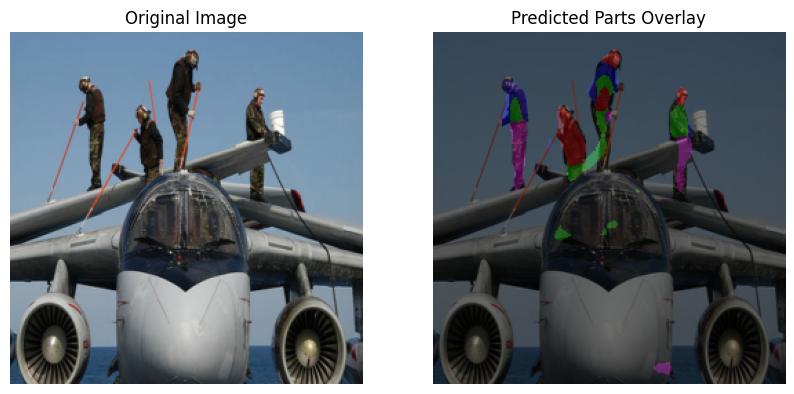

In [ ]:
# Define a color for each class (0=bg, 1=head, 2=torso, 3=upper arms, 4=lower arms, 5=upper legs, 6=lower legs)
part_colors = {
    0: (0, 0, 0),          # background: black
    1: (128, 0, 0),        # head: maroon
    2: (0, 128, 0),        # torso: green
    3: (0, 0, 128),        # arms navy
    4: (128, 0, 128),      # legs purple
    # 3: (128, 128, 0),      # upper arms: olive
    # 4: (0, 0, 128),        # lower arms: navy
    # 5: (128, 0, 128),      # upper legs: purple
    # 6: (0, 128, 128)       # lower legs: teal
}

import matplotlib.pyplot as plt

# pick a sample image from val_ds
sample_img, sample_mask = val_ds[7]
model.eval()
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device))['out'].argmax(dim=1).squeeze(0).cpu().numpy()
# Create color overlay for predicted mask
h, w = pred.shape
color_overlay = np.zeros((h, w, 3), dtype=np.uint8)
for cls_idx, color in part_colors.items():
    color_overlay[pred == cls_idx] = color
# Convert original image tensor back to PIL for visualization
# (undo normalization for correct display)
img_np = sample_img.numpy().transpose(1, 2, 0)  # to HWC
img_np = (img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))  # de-normalize
img_np = (img_np * 255).astype(np.uint8)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Original Image"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_np); plt.imshow(color_overlay, alpha=0.5);
plt.title("Predicted Parts Overlay"); plt.axis('off')
plt.show()

In [ ]:
for images, masks in val_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)['out']
    preds = outputs.argmax(dim=1).cpu().numpy()
    print("Unique predicted values:", np.unique(preds))  # Should show 0,1,2,3,4 if working properly
    break  # Just check one batch


Unique predicted values: [0 1 2 3 4]


In [ ]:
import random

Unique classes in the mask: [0 1 2 3 4]


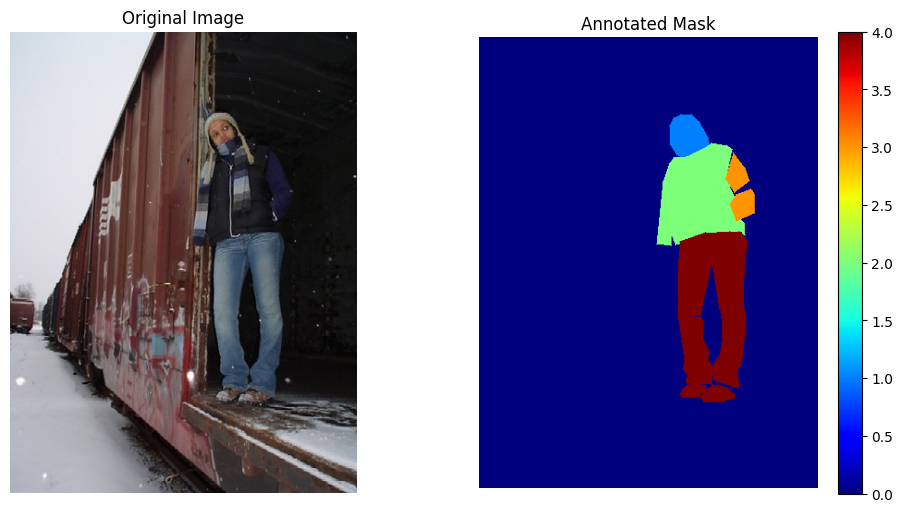

In [ ]:
# Pick a random index from your dataset
idx = random.randint(0, len(image_paths) - 1)

# Load the original image and the corresponding merged mask (as a tensor)
img_path = image_paths[idx]
mask_tensor = mask_tensors[idx]  # This is a torch tensor

# Open the image using PIL
img = Image.open(img_path).convert("RGB")
# Convert mask to a NumPy array
mask = mask_tensor.numpy()

# Print the unique values in the mask (should include 0, 1, 2, maybe 3, 4 if correctly labeled)
print("Unique classes in the mask:", np.unique(mask))

# Display the image and its mask side-by-side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='jet')
plt.title("Annotated Mask")
plt.colorbar()
plt.axis("off")
plt.show()

## Save model weights

In [ ]:
import torch
import torch.nn as nn

# Define a wrapper that returns only the 'out' tensor
class DeepLabWrapper(nn.Module):
    def __init__(self, model):
        super(DeepLabWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Return only the 'out' key from the dict output
        return self.model(x)['out']

# Move your original model to the appropriate device if needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

# Create the wrapper
wrapper_model = DeepLabWrapper(model)
wrapper_model.to(device)
wrapper_model.eval()

# Prepare dummy input (ensure it's on the same device)
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Trace the wrapped model
traced_model = torch.jit.trace(wrapper_model, dummy_input)
traced_model.save("deeplabv3_person_parts_traced.pt")
print("Model successfully traced and saved.")


Model successfully traced and saved.
